# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Оглавление<a name="Оглавление"></a>

- 1. [Подготовка данных](#Подготовка_данных)
  - 1.1. [Вывод по предобработке данных](#Вывод_предобработке)
- 2. [Обучение моделей](#Обучение_моделей)
  - 2.1 [Kодирование](#кодирование)
    - 2.1.1. [Прямое кодирование](#Прямое_кодирование)
    - 2.1.2. [OHE кодирование](#OHE)
  - 2.2. [LinearRegression](#LinearRegression_)
  - 2.3. [DecisionTreeRegressor](#DecisionTreeRegressor_)
  - 2.4. [CatBoostRegressor](#CatBoostRegressor_)
  - 2.5. [LGBMRegressor](#LGBMRegressor_)
  - 2.6. [Вывод по обучению моделей](#Вывод_моделей)
- 3. [Анализ моделей](#Анализ_моделей)
  - 3.1. [LinearRegression](#LinearRegression)
  - 3.2. [DecisionTreeRegressor](#DecisionTreeRegressor)
  - 3.3. [CatBoostRegressor](#CatBoostRegressor)
  - 3.4. [LGBMRegressor](#LGBMRegressor)
  - 3.5. [Вывод по моделям](#Вывод_моделям)
- 4. [Финальное тестирование лучшей модели](#Финальное)
- 5. [Итоговый вывод](#Итоговый_вывод)

## 1. Подготовка данных<a name="Подготовка_данных"></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor, cv

In [2]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('./datasets/autos.csv')

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Для начала удалим явные дубликаты

In [7]:
df = df.drop_duplicates()

In [8]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105795
RegistrationYear     0.000000
Gearbox              0.055968
Power                0.000000
Model                0.055607
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092828
Brand                0.000000
Repaired             0.200793
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пустые значения заменим на unknowhn

In [9]:
df['VehicleType'] = df['VehicleType'].fillna('Unknown')
df['Gearbox'] = df['Gearbox'].fillna('Unknown')
df['Model'] = df['Model'].fillna('Unknown')

В столбце Repaired будем считаь если знаение NaN то в ремонте машина не была, поэтому пустым значениям установим значение 'yes'.

In [10]:
df['Repaired'] = df['Repaired'].fillna('no')

In [11]:
df['Repaired'] .unique()

array(['no', 'yes'], dtype=object)

Oтбросим лишние столбцы

In [12]:
df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'],
          axis=1, inplace=True)

Не бывает машин с нулевой мощностью, удалим их 

In [13]:
df = df.drop(df[df['Power'] == 0].index)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314140 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              314140 non-null  int64 
 1   VehicleType        314140 non-null  object
 2   RegistrationYear   314140 non-null  int64 
 3   Gearbox            314140 non-null  object
 4   Power              314140 non-null  int64 
 5   Model              314140 non-null  object
 6   Kilometer          314140 non-null  int64 
 7   RegistrationMonth  314140 non-null  int64 
 8   FuelType           292906 non-null  object
 9   Brand              314140 non-null  object
 10  Repaired           314140 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.8+ MB


Проверим наполнение целевого признака Price.

In [15]:
df['Price'].value_counts()

0        6907
1500     4652
500      4606
1200     3934
2500     3849
         ... 
11080       1
16340       1
873         1
9530        1
10985       1
Name: Price, Length: 3623, dtype: int64

Видно, что существует 6907 записи без цены. Удалим их и проверим распределение цены на гистограмме.

count    307233.000000
mean       4809.878809
std        4586.543041
min           1.000000
25%        1300.000000
50%        3100.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64

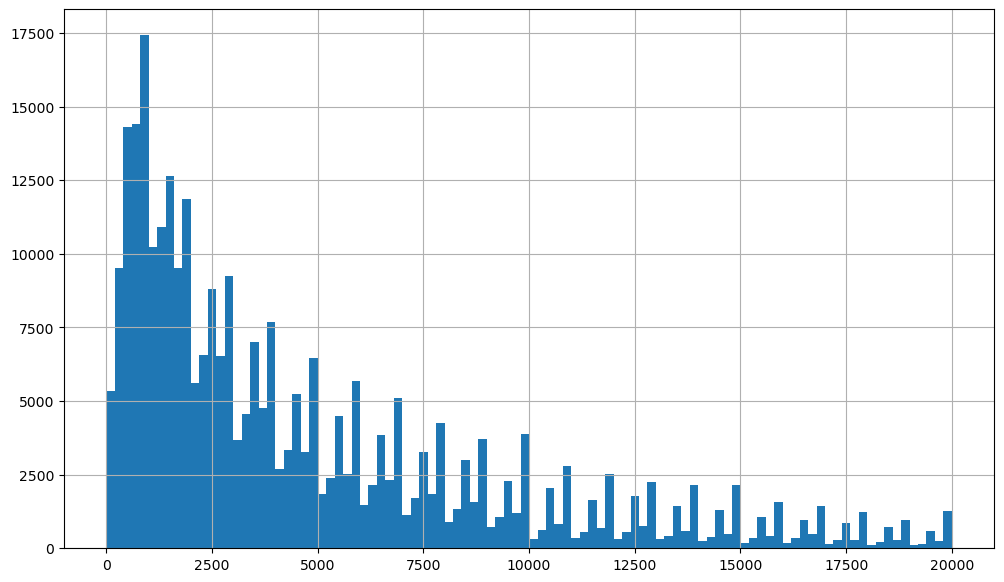

In [16]:
df = df.query('Price > 0')
df['Price'].hist(bins=100, figsize=(12,7))
df['Price'].describe()

Выделим квантили 5% и 80%.

In [17]:
df['Price'].quantile([.05, 0.8])

0.05     450.0
0.80    8100.0
Name: Price, dtype: float64

Стоимость 450 евро примерно равно 37000 рублей. Это минимальная цена для продажи поддержанного авто. Выбор 80% квантиля обоснован болльшими выбросами после 8100 евро.

In [18]:
df = df.query('450 <= Price')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292113 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              292113 non-null  int64 
 1   VehicleType        292113 non-null  object
 2   RegistrationYear   292113 non-null  int64 
 3   Gearbox            292113 non-null  object
 4   Power              292113 non-null  int64 
 5   Model              292113 non-null  object
 6   Kilometer          292113 non-null  int64 
 7   RegistrationMonth  292113 non-null  int64 
 8   FuelType           274944 non-null  object
 9   Brand              292113 non-null  object
 10  Repaired           292113 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.7+ MB


Проверим значения столбца RegistrationYear на гистограмме.

count    290598.000000
mean       2003.705125
std           6.373601
min        1976.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

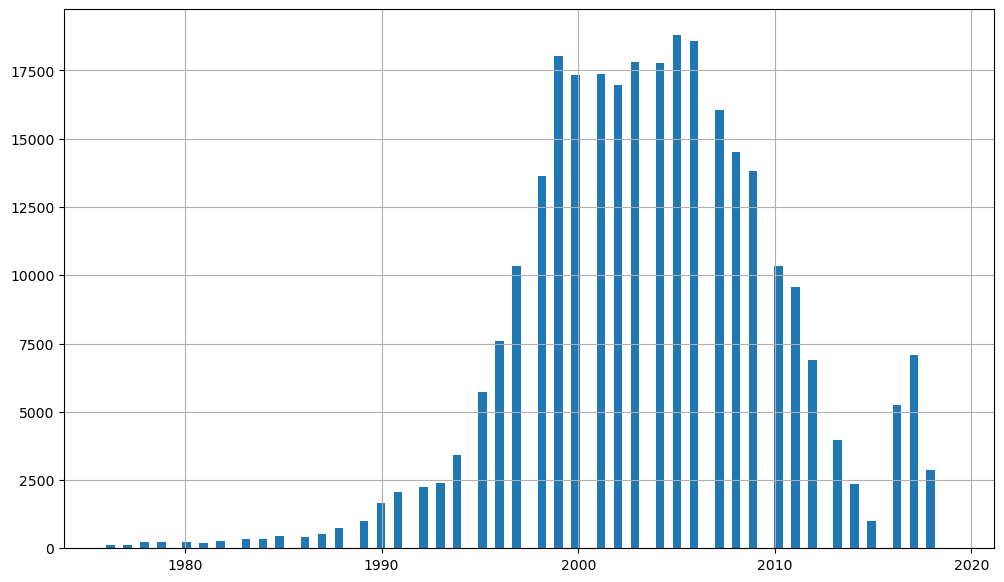

In [19]:
df = df.query('1975 < RegistrationYear < 2020')
df['RegistrationYear'].hist(bins=100, figsize=(12,7))
df['RegistrationYear'].describe()

Удалим автомобили с годом производства менее 1986 и более 2020

In [20]:
df = df.loc[df['RegistrationYear'] < 2020]
df = df.loc[df['RegistrationYear'] > 1975]

Проверим значения столбца Power на гистограмме.

count    290598.000000
mean        126.048483
std         191.979332
min           1.000000
25%          80.000000
50%         115.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

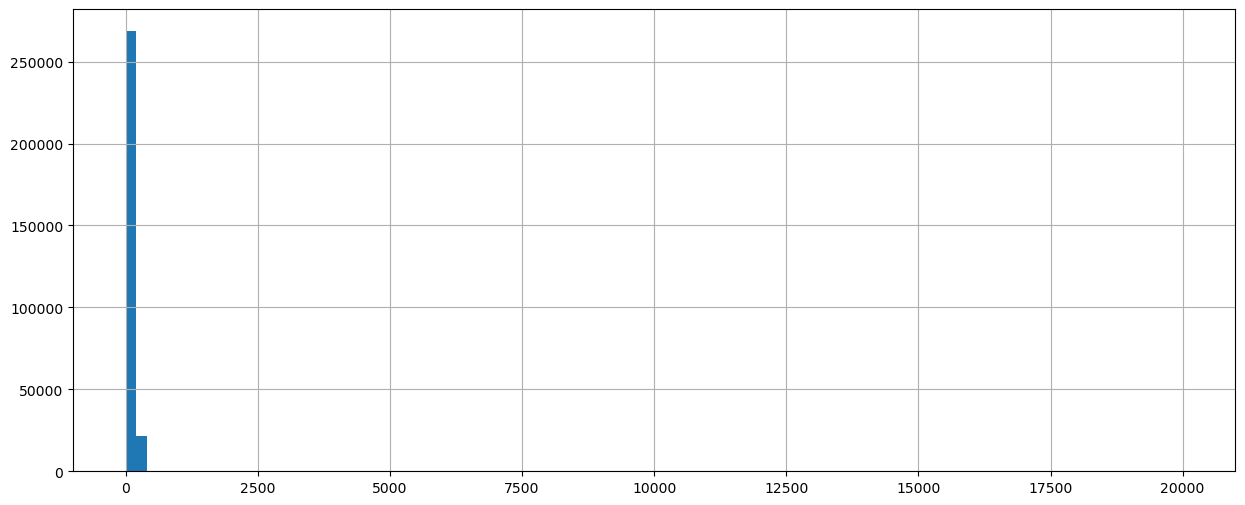

In [21]:
df['Power'].hist(bins=100, figsize=(15,6))
df['Power'].describe()

Раброс очень сильный, усечем выбросы

In [22]:
df['Power'].quantile([.05, 0.8])

0.05     57.0
0.80    163.0
Name: Power, dtype: float64

In [23]:
df = df.query('54 <= Power')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282543 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              282543 non-null  int64 
 1   VehicleType        282543 non-null  object
 2   RegistrationYear   282543 non-null  int64 
 3   Gearbox            282543 non-null  object
 4   Power              282543 non-null  int64 
 5   Model              282543 non-null  object
 6   Kilometer          282543 non-null  int64 
 7   RegistrationMonth  282543 non-null  int64 
 8   FuelType           266278 non-null  object
 9   Brand              282543 non-null  object
 10  Repaired           282543 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.9+ MB


In [24]:
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             16265
Brand                    0
Repaired                 0
dtype: int64

Заполнение пропущенных значений категориальных признаков заглушкой unknown

In [25]:
df = df.fillna('Unknown')

In [26]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

Проведем замену столбцов Gearbox и NotRepaired на булев тип.

- IsManualGearbox. 1(manual) - означает механическую коробку передач. 0(auto) - автоматическую.
- NotRepaired. 1(yes) - означает машину без ремонта. 0(no) - с ремонтом.

In [27]:
df['IsManualGearbox'] = 0
df.loc[df['Gearbox'] == 'manual', 'IsManualGearbox'] = 1
display(df['IsManualGearbox'].value_counts())
df['Gearbox'].value_counts()

1    219553
0     62990
Name: IsManualGearbox, dtype: int64

manual     219553
auto        58216
Unknown      4774
Name: Gearbox, dtype: int64

In [28]:
df['NotRepaired'] = 0
df.loc[df['Repaired'] == 'yes', 'NotRepaired'] = 1
display(df['NotRepaired'].value_counts())
df['Repaired'].value_counts()

0    258968
1     23575
Name: NotRepaired, dtype: int64

no     258968
yes     23575
Name: Repaired, dtype: int64

Удалим ненужные столбцы и уменьшим размерность хранения типа для ускорения работы с дата фреймом.

In [29]:
df.drop(['Repaired','Gearbox'], inplace=True, axis=1)
df['NotRepaired'] = pd.to_numeric(df['NotRepaired'], downcast='integer')
df['IsManualGearbox'] = pd.to_numeric(df['IsManualGearbox'], downcast='integer')
df['RegistrationYear'] = pd.to_numeric(df['RegistrationYear'], downcast='integer')
df['Power'] = pd.to_numeric(df['Power'], downcast='integer')
df['Kilometer'] = pd.to_numeric(df['Kilometer'], downcast='integer')
df['Price'] = pd.to_numeric(df['Price'], downcast='integer')

[К оглавлению](#Оглавление)

## 1.1. Вывод по предобработке данных <a name="Вывод_предобработке"></a>

- Mы удалили ненужные явные дубликаты;
- Заполнили пропуски в данных наиболее подходящими значениями;
- Поменяли в некоторых столбцах тип данных;
- Посмотрели на общее распределение по данным;
- Посмотрев на корреляцию в данных выявили признаки наиболее кореллирующие с целевым признаком и по нему предобработали выбросы
- Hа последнем шаге мы избаивились от ненужных столбцов.

## 2. Обучение моделей<a name="Обучение_моделей"></a>

Подготовим три типа признаков для кроссвалидации:

- Неизмененные. Название original_features.
- Закодированные методом OHE. Название ohe_features.
- Закодированные методом OE. Название ordinal_features.

Выделим неизменные признаки и целевой

In [30]:
original_features = df.drop('Price', axis=1)
target = df['Price']

[К оглавлению](#Оглавление)

### 2.1. Кодирование <a name="кодирование"></a>

#### 2.1.1 Прямое кодирование<a name="Прямое_кодирование"></a>

In [31]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

#### 2.1.2 OHE кодирование<a name="OHE"></a>

In [32]:
ohe_features = pd.get_dummies(original_features, drop_first=True)

In [33]:
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=19072020)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

[К оглавлению](#Оглавление)

### 2.2. LinearRegression<a name="LinearRegression_"></a>

In [34]:
%%time

regressor = LinearRegression()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Среднее значение RMSE из CV линейной регрессии =', cv_RMSE_LR)

Среднее значение RMSE из CV линейной регрессии = 2647.585281726155
Wall time: 11.7 s


In [35]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Среднее значение RMSE из CV линейной регрессии =', cv_RMSE_LR_S)

Среднее значение RMSE из CV линейной регрессии = 4802905846560.559
Wall time: 18.2 s


Масштабирование признаков ухудшает модель. Откажемся от применение масштаба.

[К оглавлению](#Оглавление)

### 2.3. DecisionTreeRegressor<a name="DecisionTreeRegressor_"></a>

Проведем два эксперимента.

- Проверим модель на принаках, закодированных по методу OHE.
- На признаках, закодированных по методу OE.

In [36]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Наилучший набор параметров, найденный в наборе для разработки:")
print()
print(clf.best_params_)
print()
print("Баллы сетки по набору разработки:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

Наилучший набор параметров, найденный в наборе для разработки:

{'criterion': 'mse', 'max_depth': 15, 'random_state': 12345}

Баллы сетки по набору разработки:

3280.479703 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2990.153792 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2701.905948 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2485.392280 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2329.713973 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2204.395179 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2122.730289 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
2056.537419 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
2007.845663 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1965.634010 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1935.646547 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}


In [37]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 31)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Наилучший набор параметров, найденный в наборе для разработки:")
print()
print(clf.best_params_)
print()
print("Баллы сетки по набору разработки:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

Наилучший набор параметров, найденный в наборе для разработки:

{'criterion': 'mse', 'max_depth': 14, 'random_state': 12345}

Баллы сетки по набору разработки:

3280.479703 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2990.153792 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2703.935802 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2487.879873 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2335.468087 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}
2204.136081 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 12345}
2114.543379 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 12345}
2053.749267 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 12345}
1997.909465 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 12345}
1955.775772 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 12345}
1926.060229 for {'criterion': 'mse', 'max_depth': 12, 'random_state': 12345}


Обучение на OHE данных дало похожий результат, что и порядковое кодирование признаков. Занесем оба эксперимента в финальную таблицу.

[К оглавлению](#Оглавление)

### 2.4. CatBoostRegressor<a name="CatBoostRegressor_"></a>

Проведем два эксперимента.

- Обучим модель на данных, закодированных по методу OE.
- Обучим на оригинальных данных с указанием категорий.

In [38]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Наилучший набор параметров:")
print()
print(clf.best_params_)
print()
print("Баллы сетки по набору разработки:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

Наилучший набор параметров:

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

Баллы сетки по набору разработки:

1604.613966 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1567.127291 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1603.714955 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

Wall time: 2min 59s


In [39]:
%%time

regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 200,
                              random_state=12345, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 

cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Среднее значение RMSE из CV CatBoostRegressor =', cv_RMSE_CBR_original)

Среднее значение RMSE из CV CatBoostRegressor = 1621.6974570233033
Wall time: 1min 25s


[К оглавлению](#Оглавление)

### 2.5. LGBMRegressor<a name="LGBMRegressor_"></a>

In [40]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[31, 100, 200], 
                'learning_rate':[0.1, 0.3, 0.5],
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Наилучший набор параметров:")
print()
print(clf.best_params_)
print()
print("Баллы сетки по набору разработки:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 169525, number of used features: 10
[LightGBM] [Info] Start training from score 5110.816151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 169525, number of used features: 10
[LightGBM] [Info] Start training from score 5120.886819
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 169525, number of used features: 10
[LightGBM] [Info] Start training from score 5110.816151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 169525, number of used features: 10
[LightGBM] [Info] Start training from score 5120.886819
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 169525, number of used features: 10
[LightGBM] [Info] Start training from score 5120.886819
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 169526, number of used features: 10
[LightGBM] [Info] Start training from score 5109.863171
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memo

### 2.6. Вывод по обучению моделей<a name="Вывод_моделей"></a>

- Были изучены 4 регрессионных моделей. Зафиксированы лучшие гиперпараметры и время их выполнения.
- Быстрее всего работает линейная регрессия, лучшая по показателю rmse LGBMRegressor, на этих двух моделях мы и протестируем наши тестовый данные

[К оглавлению](#Оглавление)

##  3. Анализ моделей <a name="Анализ_моделей"></a>

### 3.1. LinearRegression<a name="LinearRegression"></a>

In [41]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

Wall time: 2.83 s


LinearRegression()

In [42]:
%%time

target_predict = model.predict(ohe_features_train)

Wall time: 458 ms


[К оглавлению](#Оглавление)

### 3.2. DecisionTreeRegressor<a name="DecisionTreeRegressor"></a>

In [43]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=12345) 
model.fit(ohe_features_train, target_train);

Wall time: 4.89 s


DecisionTreeRegressor(criterion='mse', max_depth=15, random_state=12345)

In [44]:
%%time

target_predict = model.predict(ohe_features_train)

Wall time: 259 ms


In [45]:
%%time

model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=14, 
                              random_state=12345) 
model.fit(ordinal_features_train, target_train);

Wall time: 482 ms


DecisionTreeRegressor(criterion='mse', max_depth=14, random_state=12345)

In [46]:
%%time

target_predict = model.predict(ordinal_features_train)

Wall time: 30.9 ms


[К оглавлению](#Оглавление)

### 3.3. CatBoostRegressor<a name="CatBoostRegressor"></a>

In [47]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=12345, 
                          verbose=False) 
model.fit(ordinal_features_train, target_train)

Wall time: 13.1 s


In [48]:
%%time

target_predict = model.predict(ordinal_features_train)

Wall time: 35.9 ms


In [49]:
%%time

model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

Wall time: 17.7 s


In [50]:
%%time

target_predict = model.predict(original_features_train)

Wall time: 269 ms


[К оглавлению](#Оглавление)

### 3.4. LGBMRegressor<a name="LGBMRegressor"></a>

In [51]:
%%time
model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model.fit(ordinal_features_train, target_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 211907, number of used features: 10
[LightGBM] [Info] Start training from score 5119.450084
Wall time: 655 ms


LGBMRegressor(num_leaves=200, random_state=12345)

In [52]:
%%time
target_predict = model.predict(ordinal_features_train)

Wall time: 248 ms


[К оглавлению](#Оглавление)

## 3.5 Вывод по моделям<a name="Вывод_моделям"></a>

- Мы выбрали 4 модели для тестирования (линейная регрессия, дерево решений, LGBMRegressor, CatBoostRegressor)
- Модели поделили на группы и для каждой закодировали признаки(ohe и ordinal)
- После чего обучили модели и проверили сколько по времени обучается модели, сколько она предсказывает и с каким показателем rmse
- Наибольшую точность в прогнозах даёт алгоритм градиентного бустинга, он обучается так же быстро как и решающее дерево, но делает более точные прогнозы. Данный алгоритм больше всего подходит для составлення финальной модели. Если необходимо быстро построить модель и оценить результат, то можно использовать решающее дерево, так как оно даёт более высокую точноть, по сравнению с линейной регрессией и обучается гараздо быстрее бустинга.

## 4. Финальное тестирование лучшей модели<a name="Финальное"></a>

In [53]:
%%time
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=12345) 
model.fit(ohe_features_train, target_train)

Wall time: 4.75 s


DecisionTreeRegressor(criterion='mse', max_depth=15, random_state=12345)

In [54]:
%%time
target_predict = model.predict(ohe_features_test)

Wall time: 99.1 ms


In [55]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE_DTR_ohe 

1846.3913286306606

In [56]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE':[cv_RMSE_LR,
                cv_RMSE_DTR_ohe,
                cv_RMSE_DTR_ordinal,
                cv_RMSE_CBR_ordinal,
                cv_RMSE_CBR_original,
                cv_RMSE_LGBMR],
        'Время обучения на CV, мин':[3.10,
                                     10.58,
                                     1.28,
                                     6.54,
                                     2.18,
                                     40],
        'Время обучения модели, сек':[18.1,
                                      31.5,
                                      4.83,
                                      0.479,
                                      126,
                                      14.7],
        'Время предсказания модели, сек':[17.6,
                                          5.37,
                                          0.590,
                                          27.3,
                                          29.8,
                                          202]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE'].min() /
                              scores_data['RMSE'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,RMSE,"Время обучения на CV, мин","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,2647.585282,3.10,18.100,17.60,0.587809,0.026464,0.033523,0.647796
DecisionTreeRegressor on OHE features,1887.987880,10.58,31.500,5.37,0.824304,0.015206,0.109870,0.949380
DecisionTreeRegressor on OE features,1906.024407,1.28,4.830,0.59,0.816503,0.099172,1.000000,1.915675
CatBoostRegressor on OE features,1567.127291,6.54,0.479,27.30,0.993075,1.000000,0.021612,2.014687
CatBoostRegressor on original features,1621.697457,2.18,126.000,29.80,0.959658,0.003802,0.019799,0.983259
LGBMRegressor,1556.275529,40.00,14.700,202.00,1.000000,0.032585,0.002921,1.035506


[К оглавлению](#Оглавление)

## 5. Итоговый вывод:<a name="Итоговый_вывод"></a>

Для общей оценки по трем параметрам был создан относительный рейтинг. 1 получает регрессор с самым минмальным временем или RMSE. Остальные получают рейтинг как отношение лучшего в столбце к своему значению. Считаем, что все параметры равноценны.

На выбор модели не влияло время обучения на кросвалидации, так как на одном типе данных ее проводят один раз. В то время переобучить модель на новых данных приходится намного чаще.

1) Лучшей моделью по трем параметрам качество, скорость обучения и скорость предсказания можно считать DecisionTreeRegressor. Сочетания скорости и точности на подготовленных данных выводит его в лидеры рейтинга. Все остальные показали себя в целом хуже.

2) Если рассматривать только оценивание точности, то в лидеры выходит LGBMRegressor. Следом за ним идет CatBoostRegressor и DecisionTreeRegressor занимает третье место.

3) LinearRegression показали себя на этой задачи очень слабо.

Исходя из полученного рейтинга можно выделить специфику задач для регрессоров.

- Для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor с подготовленными признаками.
- Если в деле важна точность и есть время регрессор LGBMRegressor поможет предсказать лучше всех.
- Для задач, не требующих сильной предобработки и заготовки данных CatBoostRegressor может показать себя очень хорошо.